# Figure 3: Turbulence

- Panel (a): Elasser modes [km/s]
- Panel (b): Fluctuations [km/s]
- Panel (c): Angle VB [deg]
- Panel (d): $\sigma_C$ vs. $\sigma_R$ 

In [1]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats


import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs
from tools.plotting import plot_pfss
from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

# REGIONS
loc_hcs = [61.8, 62.2]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
RES_DIR = os.path.join('/Users/tamarervin', 'e15_results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


## Import Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pp='parker20min.csv')

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

27-Dec-23 09:41:10: /Users/tamarervin/publications/e15/tools/utilities.py:169: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

27-Dec-23 09:41:10: /Users/tamarervin/publications/e15/tools/utilities.py:169: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

27-Dec-23 09:41:12: /Users/tamarervin/publications/e15/tools/utilities.py:178: FutureWarning: 'loffset' in .resample() and in Grouper() is d

# Figure 3: Turbulence

- Left Panels: Timeseries 
- Right Panel: cross helcity vs. residual energy comparison

27-Dec-23 09:43:16: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


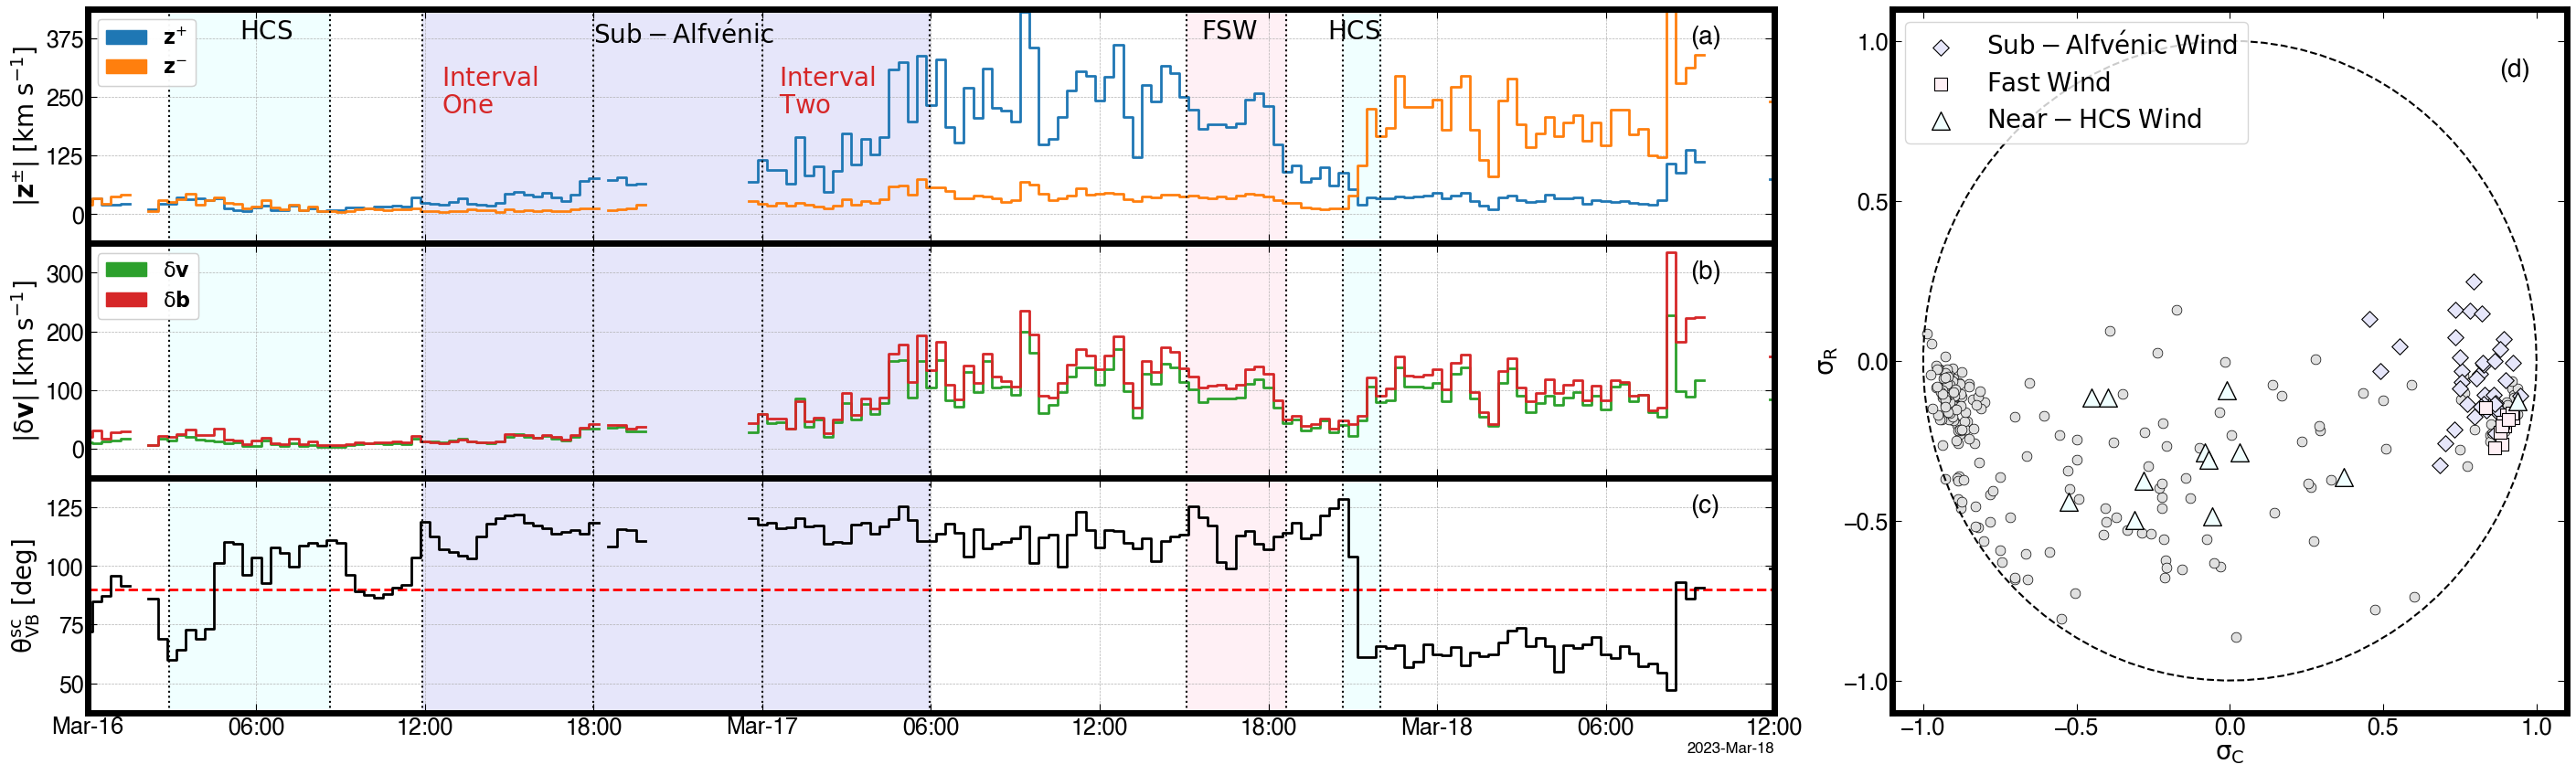

In [3]:
### SETUP FIGURE
fig = plt.figure(figsize=(35, 10))
ss=80
lw=2
grid = plt.GridSpec(3, 2, width_ratios=[5, 2], wspace=0.1, hspace=0)
plt.rcParams['axes.linewidth'] = 5

### ADD REGIONS ###
regions = [
    (parker[hhcs].Time.iloc[0], parker[hhcs].Time.iloc[-1], hcol),
    (parker[hhcs1].Time.iloc[0], parker[hhcs1].Time.iloc[-1], hcol),
    (parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1], scol),
    (parker[fast].Time.iloc[0], parker[fast].Time.iloc[-1], fcol)
]

lines = [
    parker[hhcs].Time.iloc[0],
    parker[hhcs].Time.iloc[-1],
    parker[hhcs1].Time.iloc[0],
    parker[hhcs1].Time.iloc[-1],
    parker[slow].Time.iloc[0],
    parker[slow].Time.iloc[-1],
    parker[fast].Time.iloc[0],
    parker[fast].Time.iloc[-1],
    pd.Timestamp('2023-03-16 18:00'),
    pd.Timestamp('2023-03-17 00:00')
]

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm |\mathbf{z}^{\pm}| \; [km \; s^{-1}]$',
            r'$\rm |\delta \mathbf{v}| \; [km \; s^{-1}]$',
            r'$\rm \theta_{VB}^{sc} \; [deg]$',  
            r'$\rm \delta \mathbf{B} / |\mathbf{B}|$',
            r'$\rm \sigma_C$',
            r'$\rm \sigma_R$'
            ]

### DEFINE DATA, LABELS, COLORMAPS
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

##### ---------- PANEL (A): ELASSER VARIABLES  ---------- ######
ax = plt.subplot(grid[0, 0])
cc = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

### PLOT THE DATA ###
data = ['Zp', 'Zm']
for i, vv in enumerate(data):
    ax.step(pss.Time, pss[vv], c=cc[i], linewidth=lw, zorder=2)

### ADD Y-LABEL ###
ax.set_ylabel(ylabel=ylabels[0], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### ADD AXES LIMITS ###
ax.set_xlim(pd.Timestamp('2023-03-16 00:00:00'), pd.Timestamp('2023-03-18 12:00:00'))
ax.set_xticklabels([])
# ax.set(ylim=(-50, 250), yticks=np.arange(0, 301, step=100)) 
ax.set(ylim=(-62.5, 437.5), yticks=np.arange(0, 400, step=125)) 

### ADD THE GRID ###
ax.grid(True, linestyle='--', linewidth=0.5)


### PLOT LINES AND REGIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=5)

for region in regions:
    ax.axvspan(region[0], region[1],color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, panel_labels[0], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.sharex(plt.subplot(grid[1, 0]))

### LEGEND ###
C_patch = mpatches.Patch(color=cc[0], label=r'$\rm \mathbf{z}^{+}$')
R_patch = mpatches.Patch(color=cc[1],  label=r'$\rm \mathbf{z}^{-}$')
leg0 = ax.legend(handles=[C_patch, R_patch], loc='upper left', fontsize=16)
ax.add_artist(leg0)

##### ---------- PANEL (B): FLUCTUATIONS  ---------- ######
ax = plt.subplot(grid[1, 0])

### PLOT THE DATA
data = ['deltav', 'deltab']
for i, vv in enumerate(data):
    ax.step(pss.Time, pss[vv], c=cc[2+i], linewidth=lw, zorder=2)

### ADD Y-LABEL ###
ax.set_ylabel(ylabel=ylabels[1], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### ADD AXES LIMITS ###
ax.set_xlim(pd.Timestamp('2023-03-16 00:00:00'), pd.Timestamp('2023-03-18 12:00:00'))
ax.set_xticklabels([])

# ax.set(ylim=(-25, 175), yticks=np.arange(0, 151, step=50)) 
ax.set(ylim=(-50, 350), yticks=np.arange(0, 301, step=100)) 

### ADD THE GRID ###
ax.grid(True, linestyle='--', linewidth=0.5)

### PLOT LINES AND REGIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=5)

for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, panel_labels[1], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### LEGEND ###
C_patch = mpatches.Patch(color=cc[2], label=r'$\rm \delta \mathbf{v}$')
R_patch = mpatches.Patch(color=cc[3],  label=r'$\rm \delta \mathbf{b}$')
leg0 = ax.legend(handles=[C_patch, R_patch], loc='upper left', fontsize=16)
ax.add_artist(leg0)

##### ---------- PANEL (C): ANGLE  ---------- ######
ax = plt.subplot(grid[2, 0])

### PLOT THE DATA
ax.axhline(90, color='red', linestyle='dashed', lw=2)
ang_deg = (np.array(pss['angle_vb'])*u.rad).to(u.degree)
ax.step(pss.Time, ang_deg, c='k', linewidth=lw, zorder=2)

### ADD Y-LABEL ###
ax.set_ylabel(ylabel=ylabels[2], fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### ADD AXES LIMITS ###
ax.set_xlim(pd.Timestamp('2023-03-16 00:00:00'), pd.Timestamp('2023-03-18 12:00:00'))
ax.set(ylim=(37.5, 137.5), yticks=np.arange(50, 126, step=25)) 
# ax.set_xticklabels([])

### ADD THE GRID ###
ax.grid(True, linestyle='--', linewidth=0.5)

### PLOT LINES AND REGIONS ###
for line in lines:
    ax.axvline(line, color='k', linestyle='dotted', zorder=5)

for region in regions:
    ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

### ADD PANEL LABELS ###
ax.text(0.95, 0.93, panel_labels[2], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

##### ---------- PANEL (D): CROSS HELICITY & RESIDUAL ENERGY  ---------- ######
ax = plt.subplot(grid[:, 1])

### PLOT DATA ###
df = pss
s = np.logical_and(df.sslon >=ssw[0], df.sslon <=ssw[1])
f = np.logical_and(df.sslon >=fsw[0], df.sslon <=fsw[1])
h = np.logical_or(np.logical_and(df.sslon >=loc_hcs[0], df.sslon <=loc_hcs[1]), np.logical_and(df.sslon >=loc_hcs1[0], df.sslon <=loc_hcs1[1]))
o = np.logical_or(np.logical_or(s, f), h)
ax.scatter(df.sigmac[~o], df.sigmar[~o], c='#E0E0E0', s=ss-20, edgecolor='k', linewidth=0.5)
ax.scatter(df.sigmac[s], df.sigmar[s], c=scol, s=ss, edgecolor='k', marker='D', linewidth=0.8, zorder=2, label=r'$\rm Sub-Alfv\'enic \; Wind$')
ax.scatter(df.sigmac[f], df.sigmar[f], c=fcol, s=ss+20, edgecolor='k', marker='s', linewidth=0.8, zorder=2, label=r'$\rm Fast \; Wind$')
ax.scatter(df.sigmac[h], df.sigmar[h], c=hcol, s=200, edgecolor='k', marker='^', linewidth=1, zorder=3, label=r'$\rm Near-HCS \; Wind$')
ax.legend(loc='upper left', fontsize=20)

### PLOT CIRCLES ###
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
ax.plot(x, y, linestyle='dashed', c='k')

### TICK MARKS AND LABELS ###
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.text(0.90, 0.93, panel_labels[3], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm \sigma_C$', fontsize=20)
ax.set_ylabel(r'$\rm \sigma_R$', fontsize=20)
ax.set(xlim=(-1.1, 1.1), xticks=np.arange(-1, 1.1, step=0.5), ylim=(-1.1, 1.1), yticks=np.arange(-1, 1.1, step=0.5))

##### ---------- LABEL REGIONS OF INTEREST ---------- ######
ax = plt.subplot(grid[0, 0])
ax.text(0.09, 0.95, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.30, 0.95, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.66, 0.95, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.735, 0.95, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

ax.text(0.21, 0.75, r'$\rm Interval$' + '\n' +r'$\rm One$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='tab:red')
ax.text(0.41, 0.75, r'$\rm Interval$' + '\n' +r'$\rm Two$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='tab:red')

plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig3.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig3.eps')), bbox_inches='tight')


In [ ]:

##### ---------- PANEL (D): COMPRESSIBILITY  ---------- ######
# ax = plt.subplot(grid[3, 0])

# ### PLOT THE DATA
# ax.step(pss.Time, np.abs(pss.deltab)/np.abs(pss.B), c='k', linewidth=lw, zorder=2)

# ### ADD THRESHOLD
# ax.axhline(1, c='red', linestyle='dashed', lw=2)

# ### ADD Y-LABEL ###
# ax.set_ylabel(ylabel=ylabels[3], fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=18) 

# ### ADD AXES LIMITS ###
# ax.set_xlim(pd.Timestamp('2023-03-16 00:00:00'), pd.Timestamp('2023-03-18 12:00:00'))
# ax.set_yscale('log')

# ### ADD THE GRID ###
# ax.grid(True, linestyle='--', linewidth=0.5)

# ### PLOT LINES AND REGIONS ###
# for line in lines:
#     ax.axvline(line, color='k', linestyle='dotted', zorder=5)

# for region in regions:
#     ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

# ### ADD PANEL LABELS ###
# ax.text(0.95, 0.93, panel_labels[3], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')